<a href="https://colab.research.google.com/github/colarrbear/DA-opinion_analytics/blob/main/DA-opinion_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aspect-Based Sentiment Analysis (ABSA) for Sephora Product Reviews

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
import string

import warnings
warnings.filterwarnings('ignore')

In [73]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/maysahs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maysahs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/maysahs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [74]:
# Load product info dataset
product_df = pd.read_csv('datasets/product_info.csv')
product_df.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [75]:
# Load review datasets and concatenate
review_files = [
    'datasets/reviews_0-250.csv',
    'datasets/reviews_250-500.csv',
    'datasets/reviews_500-750.csv',
    'datasets/reviews_750-1250.csv',
    'datasets/reviews_1250-end.csv'
]

reviews_list = []
for file in review_files:
    df = pd.read_csv(file)
    reviews_list.append(df)
    
if not reviews_list:
    raise ValueError("No review data was loaded. Please check file paths.")

reviews = pd.concat(reviews_list, ignore_index=True)

## Data Loading and Exploration

In [76]:
# Basic exploration
print(f"Product info shape: {product_df.shape}")
print(f"Reviews shape: {reviews.shape}")

Product info shape: (8494, 27)
Reviews shape: (1094411, 19)


In [77]:
# Display the first few rows of each dataset
product_df.head()
reviews.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [78]:
# Check for missing values
print("Missing values in product_info:")
print(product_df.isnull().sum())

print("\nMissing values in reviews:")
print(reviews.isnull().sum())

# Basic statistics
print("\nBasic statistics for numerical columns in product_info:")
product_df.describe()

print("\nBasic statistics for numerical columns in reviews:")
reviews.describe()

Missing values in product_info:
product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

Missing values in reviews:
Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count   

,Unnamed: 0,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd
count,1.094411e+06,1.094411e+06,926423.000000,532819.000000,1.094411e+06,1.094411e+06,1.094411e+06,1.094411e+06
mean,1.989864e+05,4.299158e+00,0.839962,0.767782,4.177126e+00,8.948695e-01,3.282257e+00,4.900838e+01
std,1.749886e+05,1.149444e+00,0.366642,0.317164,2.271524e+01,5.288943e+00,1.967482e+01,4.004338e+01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,5.590600e+04,4.000000e+00,1.000000,0.652174,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01
50%,1.308240e+05,5.000000e+00,1.000000,0.928571,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01
75%,3.285265e+05,5.000000e+00,1.000000,1.000000,3.000000e+00,1.000000e+00,3.000000e+00,6.200000e+01
max,6.021290e+05,5.000000e+00,1.000000,1.000000,5.464000e+03,1.159000e+03,5.050000e+03,1.900000e+03


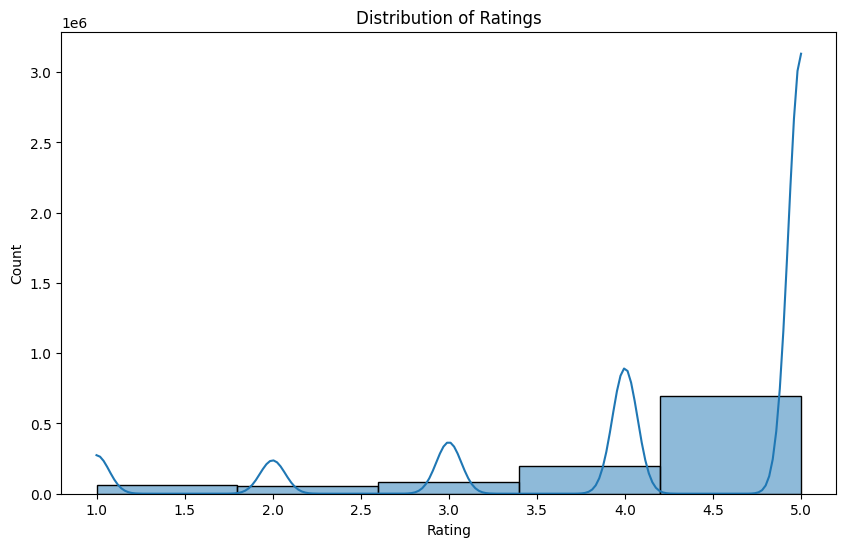

In [79]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(reviews['rating'], bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

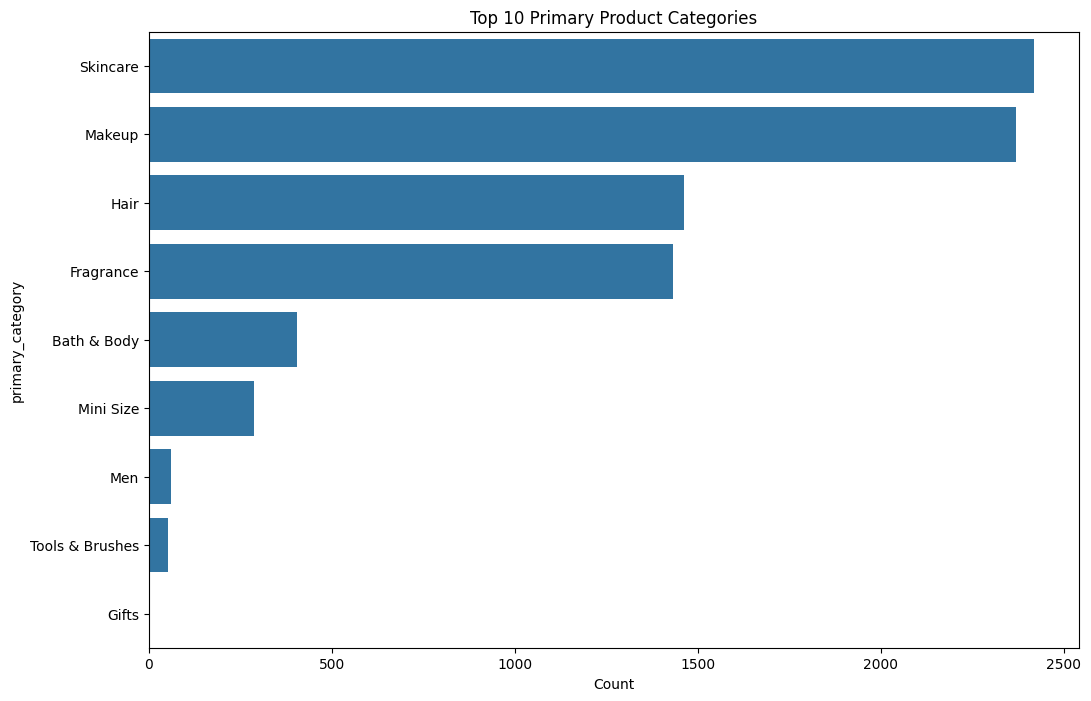

In [80]:
# Distribution of product categories
plt.figure(figsize=(12, 8))
primary_categories = product_df['primary_category'].value_counts().head(10)
sns.barplot(x=primary_categories.values, y=primary_categories.index)
plt.title('Top 10 Primary Product Categories')
plt.xlabel('Count')
plt.show()

## Data Preprocessing and Cleaning

In [81]:
# Merge product information with reviews on product_id
merged_data = pd.merge(reviews, product_df, on=['product_id', 'product_name', 'brand_name', 'price_usd'], how='inner')

# Check shape after merging
print(f"Merged data shape: {merged_data.shape}")

Merged data shape: (1094411, 42)


In [82]:
# Create a function to clean review text
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Clean review text
merged_data['clean_review_text'] = merged_data['review_text'].apply(clean_text)
merged_data['clean_review_title'] = merged_data['review_title'].apply(clean_text)

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    if pd.isna(text) or text == "":
        return []
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    
    return tokens

# merged_data['tokens'] = merged_data['clean_review_text'].apply(tokenize_and_lemmatize)

# Create a column with joined tokens for further analysis
#merged_data['processed_text'] = merged_data['tokens'].apply(lambda x: ' '.join(x))

# Check the results
#merged_data[['review_text', 'clean_review_text', 'processed_text']].head()

## Data Transformation and Feature Engineering

In [86]:
# Create sentiment score based on rating
merged_data.columns = merged_data.columns.str.strip()
merged_data['sentiment_score'] = merged_data['rating_x'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

In [83]:
# print(repr(merged_data.columns.tolist()))


['Unnamed: 0', 'author_id', 'rating_x', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'brand_id', 'loves_count', 'rating_y', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price', 'clean_review_text', 'clean_review_title']
